# 📘 Exploratory Data Analysis
**Bias in AI-Driven Housing Price Predictions: A Case Study of the New York Metropolitan Area.**

This notebook contains the data wrangling and visualization work for Part 2 of the project.

---

## 🧾 Codebook

This dataset contains information about variables we are using.

| Variable Name | Description | Data Type | Possible Values / Range | Notes |
|---------------|-------------|-----------|--------------------------|-------|
| `Median Prices (6/30/2021)` | Core Data's most recent Housing Prices | Float | 0–33 | Listed in 100,000s |
| `Median Prices (2/28/2025)` | Zillow's most recent Housing Prices | Float | 0-34 | Listed in 100,000s |
| `airbnb_nyc_original` | Original New York AirBnb Dataset | DataSet | - | - |
| `airbnb_nyc` | Edited New York City AirBnb Dataset | DataSet | - | - |
| `home_nyc` | Edited NYC AirBnb dataset of with only entire houses/apt | Dataset | - | - |
| `nyc_dem` | CoreData NYC Neighboorhoods Dataset | Dataset | - | - |
| `zillow_values` | Zillow NYC Home Value | Dataset | - | - |


#### Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
import statsmodels.api as sm
from matplotlib.ticker import FuncFormatter
from google.colab import files

!pip install fairlearn
import fairlearn
!pip install aif360
import aif360

# suppress warnings
pd.options.mode.chained_assignment = None
pd.options.mode.copy_on_write = True

## 🧹 Data Cleaning and Wrangling

Cleaning steps taken:
- Renamed columns for clarity
- Converted date columns to datetime
- Removed rows with missing values in critical columns
- Created new calculated fields


## 🧹 Detailed Data Cleaning Notes

### What data cleaning did we do?

- **Handling Missing Values**:  
  In the initial datasets, there were rentals that did not have prices listed. We chose to remove those rows since they did not make up a large percentage of the data (about 15%) and we were planning to focus on only 10 out of the 200 neighborhoods listed.

- **Standardization & Normalization**:  
  Some of the monetary values were in scientific notation while others were not. We changed all of the monetary values to standard USD. This included dividing by appropriate factors (like 100,000) to normalize values across datasets.

- **Excluding Data**:  
  We used three different datasets from separate sources. Each one categorized information by New York City neighborhoods, but not all used the same neighborhood names or included the same areas. We chose ten neighborhoods that all three datasets had in common. These neighborhoods represent all five boroughs and were selected to show diversity in racial composition (especially white and Black resident percentages).

- **Creating Variables**:  
  We did not have to create any new variables during cleaning. We relied on existing columns such as price, race percentages, and neighborhood names.

### How did we prepare the data?

- Cleaned and standardized column names (e.g., lowercase, replacing spaces with underscores).
- Condensed datasets by keeping only the columns needed for visualizations and comparisons.
- Renamed columns where necessary to improve clarity and readability.


### AirBnb Cleaning

In [ ]:
# Load the Airbnb data
airbnb_nyc = pd.read_csv('Airbnb NYC listings (original).csv')
airbnb_nyc_original = airbnb_nyc

# Removing unnecessary columns (columns not important to our data)
columns_to_keep = airbnb_nyc.columns[[0, 4, 5, 6, 7, 8, 9]].to_list()
airbnb_nyc = airbnb_nyc[columns_to_keep]
airbnb_nyc

,id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price
0,2595,Manhattan,Midtown,40.75356,-73.98559,Entire home/apt,240.0
1,6848,Brooklyn,Williamsburg,40.70935,-73.95342,Entire home/apt,81.0
2,6872,Manhattan,East Harlem,40.80107,-73.94255,Private room,65.0
3,6990,Manhattan,East Harlem,40.78778,-73.94759,Private room,70.0
4,7064,Brooklyn,Williamsburg,40.71248,-73.95881,Private room,NaN
...,...,...,...,...,...,...,...
37779,1322024128476576885,Bronx,Kingsbridge,40.88178,-73.89973,Entire home/apt,159.0
37780,1322305006441883773,Manhattan,Financial District,40.70610,-74.00666,Entire home/apt,199.0
37781,1322523395081457963,Brooklyn,Crown Heights,40.67013,-73.95874,Private room,99.0
37782,1322561224337225530,Manhattan,Upper West Side,40.79655,-73.97462,Private room,131.0


#### Cleaning Step: Dropping Missing Values

We remove any listings that do not include a price to ensure our analysis reflects actual Airbnb costs. This helps avoid skewed or misleading results when visualizing price distributions or comparing neighborhoods.


In [ ]:
# Removing columns with missing price data
airbnb_nyc.dropna(subset = ['price'], inplace= True)
airbnb_nyc

,id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price
0,2595,Manhattan,Midtown,40.75356,-73.98559,Entire home/apt,240.0
1,6848,Brooklyn,Williamsburg,40.70935,-73.95342,Entire home/apt,81.0
2,6872,Manhattan,East Harlem,40.80107,-73.94255,Private room,65.0
3,6990,Manhattan,East Harlem,40.78778,-73.94759,Private room,70.0
5,7097,Brooklyn,Fort Greene,40.69194,-73.97389,Private room,205.0
...,...,...,...,...,...,...,...
37779,1322024128476576885,Bronx,Kingsbridge,40.88178,-73.89973,Entire home/apt,159.0
37780,1322305006441883773,Manhattan,Financial District,40.70610,-74.00666,Entire home/apt,199.0
37781,1322523395081457963,Brooklyn,Crown Heights,40.67013,-73.95874,Private room,99.0
37782,1322561224337225530,Manhattan,Upper West Side,40.79655,-73.97462,Private room,131.0


#### Focused Dataset: Entire Homes/Apartments

To maintain consistency and control for differences in accommodation type, we filtered our dataset to include only listings for entire homes/apartments — the most commonly booked type for travelers seeking privacy and amenities.


In [ ]:
# Creating dataset with only Entire home/apt rental airbnbs
home_nyc = airbnb_nyc.loc[airbnb_nyc['room_type'] == 'Entire home/apt']
# Narrow down the dataset to selected neighborhoods
home_nyc = home_nyc.loc[home_nyc['neighbourhood'].isin(['Upper East Side', 'East Harlem', 'Jamaica', 'Bushwick', 'Astoria', 'Queens Village', 'Williamsbridge', 'Williamsburg', 'Flatlands', 'Bay Ridge'])]
airbnb_nyc = airbnb_nyc.loc[airbnb_nyc['neighbourhood'].isin(['Financial District', 'East Harlem', 'Jamaica', 'Stuyvesant Town', 'Astoria', 'Forest Hills', 'Riverdale', 'Greenpoint', 'Canarsie', 'Bay Ridge'])]
home_nyc

,id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price
1,6848,Brooklyn,Williamsburg,40.709350,-73.953420,Entire home/apt,81.0
6,7801,Brooklyn,Williamsburg,40.718807,-73.956177,Entire home/apt,310.0
19,16974,Manhattan,East Harlem,40.801900,-73.937620,Entire home/apt,300.0
26,19812,Brooklyn,Williamsburg,40.718020,-73.957240,Entire home/apt,105.0
36,28907,Manhattan,Upper East Side,40.778270,-73.946690,Entire home/apt,150.0
...,...,...,...,...,...,...,...
37719,1325354149285539554,Brooklyn,Williamsburg,40.717930,-73.964130,Entire home/apt,305.0
37735,1318740134406799498,Brooklyn,Williamsburg,40.709305,-73.957810,Entire home/apt,229.0
37743,1319078032714535974,Manhattan,East Harlem,40.791200,-73.940010,Entire home/apt,86.0
37753,1320192903104387119,Brooklyn,Bushwick,40.704150,-73.920250,Entire home/apt,120.0


### Demographic Data Preparation

We load demographic data from CoreData NYC, filter for the year 2021, and select sub-borough areas that match our Airbnb data. This allows us to compare racial composition with Airbnb prices and housing trends.

In [ ]:
# Load Coredata
nyc_dem = pd.read_csv('CoreData NYC Neighboorhoods (original) .csv')

In [ ]:
# Keep relevant columns and filter
nyc_dem = nyc_dem[['region_id', 'region_name', 'region_type', 'year', 'pop_race_asian_pct', 'pop_race_white_pct', 'pop_race_black_pct', 'pop_race_hisp_pct']].dropna()
# Filter for 2021 Sub-Borough Areas only
nyc_dem = nyc_dem.loc[nyc_dem['region_type'] == 'Sub-Borough Area']
nyc_dem = nyc_dem.loc[nyc_dem['year'] == '2021']
# Keep only selected neighborhoods
nyc_dem = nyc_dem.loc[nyc_dem['region_name'].isin(['Upper East Side', 'East Harlem', 'Jamaica', 'Bushwick', 'Astoria', 'Queens Village', 'Williamsbridge/Baychester', 'Williamsburg/Greenpoint', 'Flatlands/Canarsie', 'Bay Ridge'])]

### Zillow Data: Normalization and Filtering

To analyze rental trends across New York City neighborhoods, the Zillow dataset—originally organized by ZIP code and monthly rent estimates—was first filtered to include only the last 12 months of data (March 2024 through February 2025). Since each row in the dataset corresponds to a ZIP code, and neighborhoods in NYC often span multiple ZIPs, we manually defined a mapping of ZIP codes to 10 specific neighborhoods of interest.

The ZIP code column (RegionName) was converted to integers to facilitate comparison with our defined neighborhood mappings. For each ZIP code, we calculated the average rent across the 12-month period. Then, using the predefined ZIP-to-neighborhood groupings, each ZIP code was assigned to one or more neighborhoods. If a ZIP belonged to multiple neighborhoods, its average rent was included in the calculation for each applicable group.

The cleaned data was then grouped by neighborhood, computing the mean rent across all ZIP codes within each neighborhood. This provided a single average yearly rent value per neighborhood. Finally, the results were visualized in a horizontal bar chart to clearly compare rental prices across the selected neighborhoods.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Replace with the exact file name you uploaded if it's different:
zillow_original = "Zillow NYC Rentals Zip (original).csv"

# Load the data into a pandas DataFrame
df = pd.read_csv('Zillow NYC Rentals Zip (original).csv')
# df.head()  # Take a quick look at the first few rows

# Define the zip code groupings by neighborhood
neighborhoods = {
    "Upper East Side": [10021, 10022, 10028, 10044, 10065, 10075, 10128, 10162],
    "East Harlem": [10029, 10035],
    "Williamsburg / Greenpoint": [11206, 11211, 11222, 11249],
    "Bushwick": [11206, 11207, 11221, 11237],
    "Bay Ridge": [11209, 11220, 11228],
    "Flatlands / Canarsie": [11210, 11234, 11236],
    "Astoria": [11101, 11102, 11103, 11105, 11106, 11109],
    "Queens Village": [11004, 11005, 11411, 11413, 11422, 11426, 11427, 11428, 11429],
    "Jamaica": [11412, 11423, 11432, 11433, 11434, 11435, 11436],
    "Williamsbridge / Baychester": [10466, 10467, 10469, 10470]
}

# Last 12 months of data
last_12_months = [
    "3/31/2024", "4/30/2024", "5/31/2024", "6/30/2024",
    "7/31/2024", "8/31/2024", "9/30/2024", "10/31/2024",
    "11/30/2024", "12/31/2024", "1/31/2025", "2/28/2025"
]

# Filter dataset to only include ZIP codes and the most recent 12 months of rental data
df_filtered = df[["RegionName"] + last_12_months].copy()

# Convert ZIP code field to integer so it can match with the defined ZIP lists
df_filtered["RegionName"] = df_filtered["RegionName"].astype(int)

#df_filtered.head()

# This function returns a list of neighborhoods a ZIP code belongs to, helper function
def get_neighborhoods(zip_code):
    """Return list of neighborhoods that a given zip code belongs to."""
    results = []
    for nhood, zips in neighborhoods.items():
        if zip_code in zips:
            results.append(nhood)
    return results

rows = []
# Create a list of records where each ZIP's 12-month average is assigned to its neighborhood
for _, row in df_filtered.iterrows():
    zip_code = row["RegionName"]
    nhood_list = get_neighborhoods(zip_code)

    # Skip if the zip code doesn't belong to any of the defined neighborhoods
    if not nhood_list:
        continue

    # Calculate average rent for the 12 months
    avg_rent = row[last_12_months].mean()

    # If a zip code belongs to multiple neighborhoods, we'll add multiple rows
    for nhood in nhood_list:
        rows.append({
            "ZipCode": zip_code,
            "Neighborhood": nhood,
            "AverageRent": avg_rent
        })

# Convert list of dictionaries into a new DataFrame
df_neighborhood = pd.DataFrame(rows)

# Group by neighborhood and compute the mean of these average rents
zillow_neighborhood_avg = df_neighborhood.groupby("Neighborhood")["AverageRent"].mean().reset_index()

# Sort from lowest to highest average rent to make the bar chart more readable
zillow_neighborhood_avg = zillow_neighborhood_avg.sort_values("AverageRent", ascending=True)
zillow_neighborhood_avg

,Neighborhood,AverageRent
1,Bay Ridge,2375.213515
5,Jamaica,2412.165388
7,Williamsbridge / Baychester,2431.938584
4,Flatlands / Canarsie,2595.068791
3,East Harlem,2887.972211
2,Bushwick,3183.577091
0,Astoria,3205.059020
6,Upper East Side,3846.626927
8,Williamsburg / Greenpoint,4158.591675


## 📊 Data Visualization

The following charts illustrate interesting trends in the cleaned dataset.


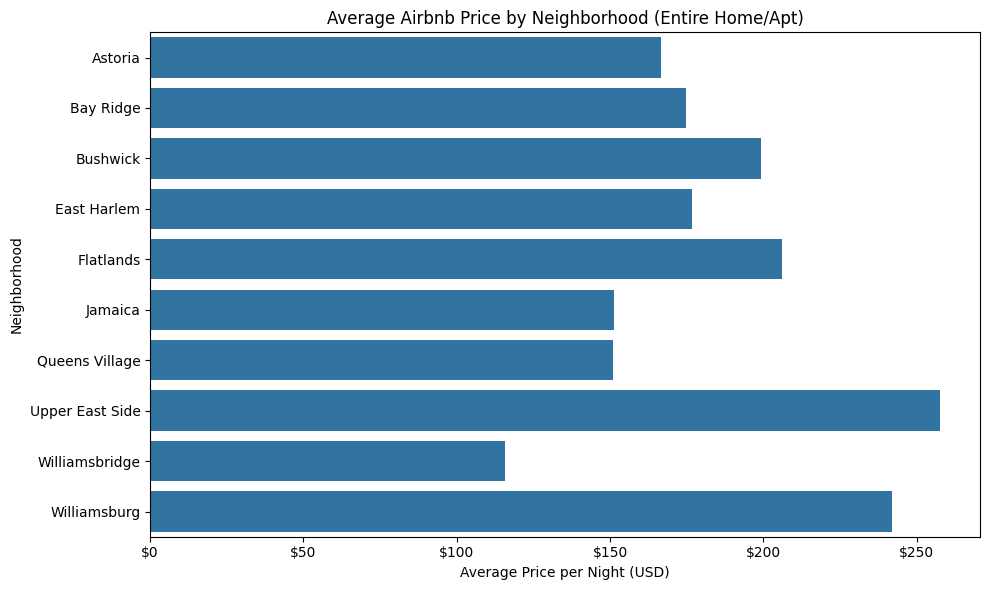

In [ ]:
import seaborn as sns
from matplotlib.ticker import FuncFormatter

# Plot using seaborn
avg_prices = home_nyc.groupby('neighbourhood')['price'].mean().reset_index()
plt.figure(figsize=(10, 6))
sns.barplot(data=avg_prices, x='price', y='neighbourhood')

plt.title('Average Airbnb Price by Neighborhood (Entire Home/Apt)')
plt.xlabel('Average Price per Night (USD)')
plt.ylabel('Neighborhood')

# Format x-axis as dollars
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"${x:,.0f}"))

plt.tight_layout()
plt.savefig("avg_airbnb_price_by_neighborhood.png", dpi=300, bbox_inches='tight')
plt.show()


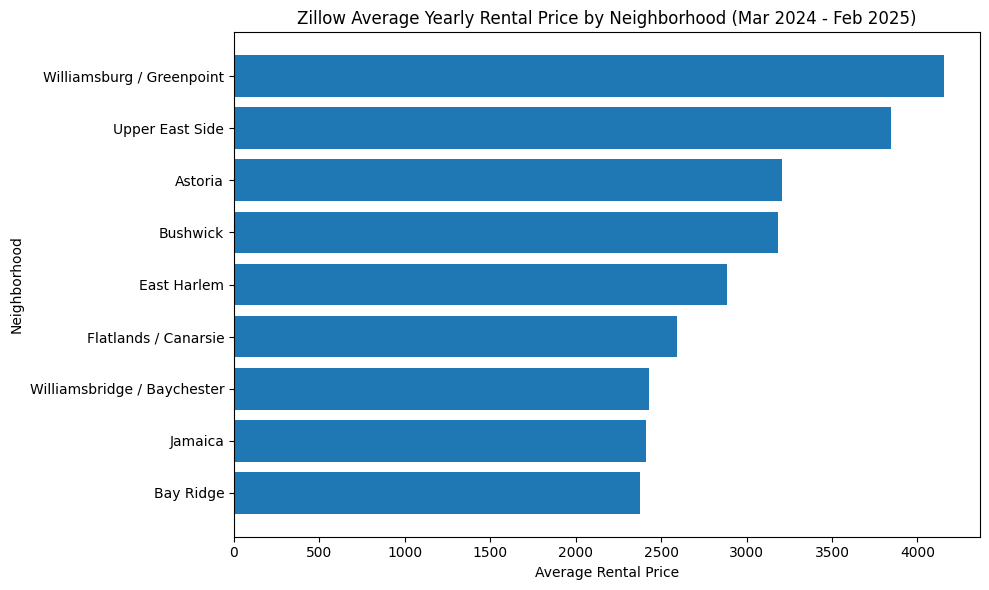

In [ ]:
# Plot a horizontal bar graph of average yearly rent by neighborhood using Zillow Data
plt.figure(figsize=(10,6))
plt.barh(zillow_neighborhood_avg["Neighborhood"], zillow_neighborhood_avg["AverageRent"])
plt.xlabel("Average Rental Price")
plt.ylabel("Neighborhood")
plt.title("Zillow Average Yearly Rental Price by Neighborhood (Mar 2024 - Feb 2025)")
plt.tight_layout()
plt.savefig("zillow_prices.png", dpi=300, bbox_inches='tight')
plt.show()

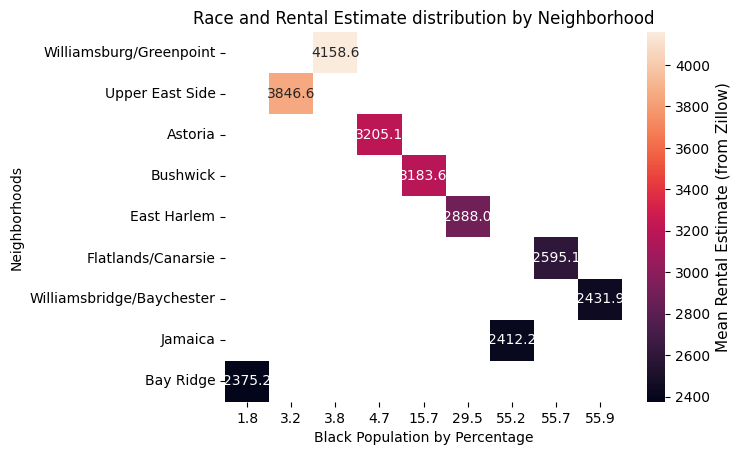

In [ ]:
# removing values that are not in both datasets
new_nyc_dem = nyc_dem.drop(index = 2163)

# creating a new dataframe for race and renat estimate heatmap
prices = zillow_neighborhood_avg["AverageRent"]
prices = prices.reindex([6, 3, 7, 8, 2, 1, 4, 0, 5])
nyc_values = new_nyc_dem[['region_name','pop_race_black_pct']]
nyc_values['prices'] = prices.tolist()
nyc_values['pop_race_black_pct'] = nyc_values['pop_race_black_pct'].str.rstrip('%').astype(float)
nyc_values = nyc_values.pivot(index = 'region_name', columns = 'pop_race_black_pct', values = 'prices')
nyc_values = nyc_values.sort_index(axis=1)  # Sorts the percentage columns in increasing order

# changing order of neighborhoods from highest to lowest rental estimate for readability
nyc_values = nyc_values.reindex(["Williamsburg/Greenpoint", 'Upper East Side', "Astoria", "Bushwick", "East Harlem", "Flatlands/Canarsie", "Williamsbridge/Baychester", "Jamaica", "Bay Ridge"])

# creates heatmap
map = sns.heatmap(nyc_values, annot = True, fmt = '.1f')
map.set(xlabel = 'Black Population by Percentage', ylabel = 'Neighborhoods')
cbar = map.collections[0].colorbar
cbar.set_label("Mean Rental Estimate (from Zillow)", fontsize = 11)
plt.title("Race and Rental Estimate distribution by Neighborhood")
plt.savefig("race_home_price_map.png", dpi=300, bbox_inches='tight')
plt.show()

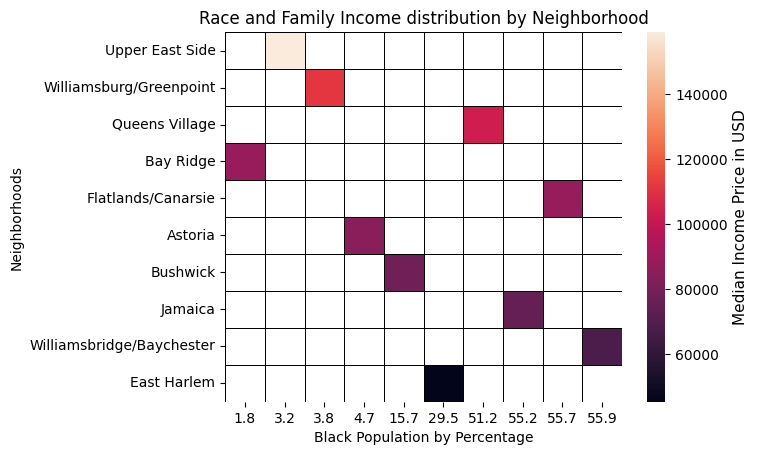

In [ ]:
# @title
neighborhood_income = pd.read_csv("CoreData NYC Neighboorhoods (original) .csv")

incomes = pd.read_csv('Income by Neighborhood.csv')

#change price values to income values sorted in same order of neighborhoods as the other heat map
nyc_values2 = nyc_dem[['region_name','pop_race_black_pct']]
nyc_values2['pop_race_black_pct'] = nyc_values2['pop_race_black_pct'].str.rstrip('%').astype(float)
income_values = [159241, 45233, 67973, 111492, 78456, 88566, 88188, 84590, 75235, 103300]
nyc_values2['incomes'] = income_values
nyc_values2 = nyc_values2.pivot(index = 'region_name', columns = 'pop_race_black_pct', values = 'incomes')
nyc_values2 = nyc_values2.sort_index(axis=1)  # sorts the columns (percentages) in increasing order
nyc_values2 = nyc_values2.reindex(['Upper East Side', "Williamsburg/Greenpoint", "Queens Village", "Bay Ridge", "Flatlands/Canarsie", "Astoria", "Bushwick", "Jamaica", "Williamsbridge/Baychester", "East Harlem"])

map2 = sns.heatmap(nyc_values2, annot = False, linecolor='black', linewidths= 0.5)
map2.set(xlabel = 'Black Population by Percentage', ylabel = 'Neighborhoods')
cbar2 = map2.collections[0].colorbar
cbar2.set_label("Median Income Price in USD", fontsize = 11)
plt.title("Race and Family Income distribution by Neighborhood")
plt.savefig("race_family_income.png", dpi=300, bbox_inches='tight')
plt.show()

/usr/local/lib/python3.11/dist-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


                            OLS Regression Results                            
Dep. Variable:              zestimate   R-squared:                       0.282
Model:                            OLS   Adj. R-squared:                 -1.154
Method:                 Least Squares   F-statistic:                    0.1965
Date:                Tue, 13 May 2025   Prob (F-statistic):              0.847
Time:                        19:17:14   Log-Likelihood:                -28.391
No. Observations:                   4   AIC:                             62.78
Df Residuals:                       1   BIC:                             60.94
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             2340.2497   5303.543  

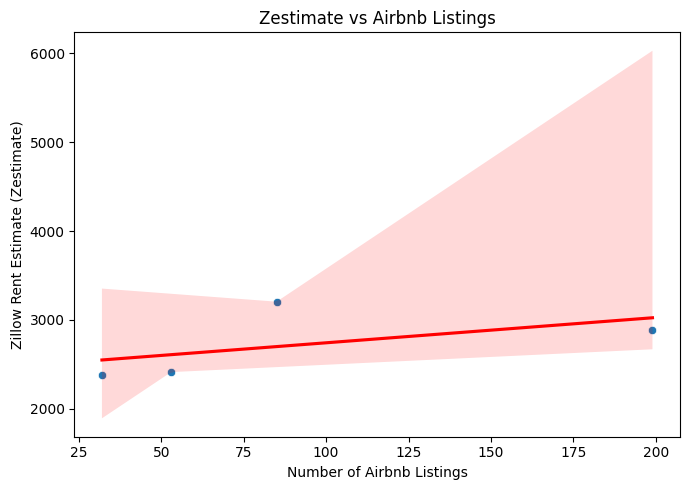

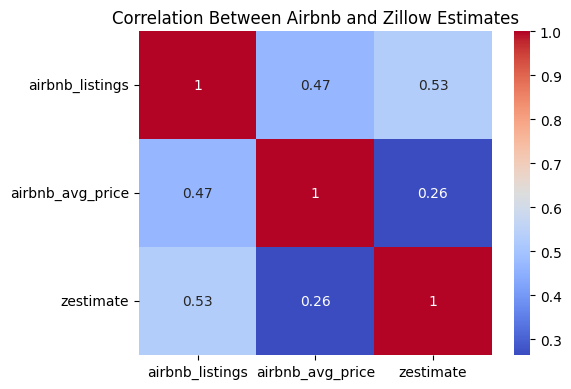

In [43]:

# Convert price column to numeric
airbnb_nyc['price'] = airbnb_nyc['price'].replace('[\$,]', '', regex=True).astype(float)
airbnb_nyc['neighbourhood'] = airbnb_nyc['neighbourhood'].str.strip()

# Group by neighborhood to compute Airbnb stats
airbnb_stats = (
    airbnb_nyc[airbnb_nyc['room_type'] == 'Entire home/apt']
    .groupby('neighbourhood')
    .agg(
        airbnb_listings=('id', 'count'),
        airbnb_avg_price=('price', 'mean')
    )
    .reset_index()
)

# Load Zillow data
zillow_neighborhood_avg.to_csv("cleaned_zillow_rent_data.csv", index=False)
zillow = pd.read_csv('cleaned_zillow_rent_data.csv')
zillow = zillow.rename(columns={'Neighborhood': 'neighbourhood', 'AverageRent': 'zestimate'})
zillow['neighbourhood'] = zillow['neighbourhood'].str.strip()

# Merge Airbnb and Zillow
merged = pd.merge(airbnb_stats, zillow, on='neighbourhood', how='inner')
merged.head()

# Run regression
X = sm.add_constant(merged[['airbnb_listings', 'airbnb_avg_price']])
y = merged['zestimate']
model = sm.OLS(y, X).fit()
print(model.summary())

# Scatterplot of Airbnb listings vs Zestimate
plt.figure(figsize=(7, 5))
sns.scatterplot(x='airbnb_listings', y='zestimate', data=merged)
sns.regplot(x='airbnb_listings', y='zestimate', data=merged, scatter=False, color='red')
plt.title('Zestimate vs Airbnb Listings')
plt.xlabel('Number of Airbnb Listings')
plt.ylabel('Zillow Rent Estimate (Zestimate)')
plt.tight_layout()
plt.show()

# Heatmap of correlation matrix
plt.figure(figsize=(6, 4))
sns.heatmap(merged[['airbnb_listings', 'airbnb_avg_price', 'zestimate']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Between Airbnb and Zillow Estimates')
plt.tight_layout()
plt.show()


In [ ]:
# Save cleaned Airbnb data
# home_nyc.to_csv("cleaned_airbnb_data.csv", index=False)

# # Save cleaned demographic data
# nyc_dem.to_csv("cleaned_demographics_data.csv", index=False)

# Save cleaned Zillow data
# zillow_neighborhood_avg.to_csv("cleaned_zillow_rent_data.csv", index=False)

# files.download('cleaned_airbnb_data.csv')
# files.download('cleaned_demographics_data.csv')
# files.download('cleaned_zillow_rent_data.csv')
# files.download("race_home_price_map.png")
# files.download("race_family_income.png")
# files.download("zillow_prices.png")
# files.download("black_population_by_neighborhood.png")
# files.download("white_population_by_neighborhood.png")
# files.download("avg_airbnb_price_by_neighborhood.png")